In [1]:
import numpy as np 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from scipy.signal import savgol_filter
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataroot = 'data/airfoil_interp.npy'
data = np.load(dataroot)

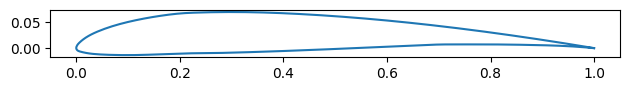

In [2]:
fig, axs = plt.subplots(1, 1)
axs.plot(data[0,:,0], data[0,:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()


In [3]:
sample = np.load('sample.npy')
# sample = np.squeeze(sample, axis=1)

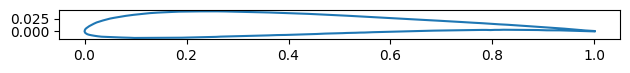

In [4]:
i = 1
fig, axs = plt.subplots(1, 1)
axs.plot(sample[i,:,0], sample[i,:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

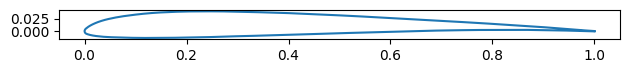

In [5]:
xhat, yhat = savgol_filter((sample[i,:,0], sample[i,:,1]), 10, 3)
fig, axs = plt.subplots(1, 1)
axs.plot(xhat, yhat)
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

In [6]:
abs(yhat[:128] - np.flip(yhat[-128:])).max()

0.05101413

In [7]:
import numpy as np
from xfoil import XFoil
from xfoil.model import Airfoil
import matplotlib.pyplot as plt
from utils import detect_intersect, Normalize, derotate
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

In [8]:
import numpy as np
from scipy.interpolate import splev, splprep, interp1d
from scipy.integrate import cumtrapz

def interpolate(Q, N, k, D=20, resolution=1000):
    ''' Interpolate N points whose concentration is based on curvature. '''
    res, fp, ier, msg = splprep(Q.T, u=None, k=k, s=1e-6, per=0, full_output=1)
    tck, u = res
    uu = np.linspace(u.min(), u.max(), resolution)
    x, y = splev(uu, tck, der=0)
    dx, dy = splev(uu, tck, der=1)
    ddx, ddy = splev(uu, tck, der=2)
    cv = np.abs(ddx*dy - dx*ddy)/(dx*dx + dy*dy)**1.5 + D
    cv_int = cumtrapz(cv, uu, initial=0)
    fcv = interp1d(cv_int, uu)
    cv_int_samples = np.linspace(0, cv_int.max(), N)
    u_new = fcv(cv_int_samples)
    x_new, y_new = splev(u_new, tck, der=0)
    xy_new = np.vstack((x_new, y_new)).T
    return xy_new

In [9]:
airfoil1D = np.loadtxt('results/airfoil1D.dat')
airfoil = np.loadtxt('results/airfoil.dat')

In [10]:
def delete_intersect(samples):
    indexs = []
    for i in range(samples.shape[0]):
        xhat, yhat = savgol_filter((samples[i,:,0], samples[i,:,1]), 10, 3)
        samples[i,:,0] = xhat
        samples[i,:,1] = yhat
        af = samples[i,:,:]
        if detect_intersect(af):
            indexs.append(i)
    for i in indexs:
        xhat, yhat = savgol_filter((samples[i,:,0], samples[i,:,1]), 10, 3)
        samples[i,:,0] = xhat
        samples[i,:,1] = yhat
        af = samples[i,:,:]
        point = 1.0
        while detect_intersect(af):
            indexs = []
            for index in range(af.shape[0]):
                if af[index,0] > point:
                    indexs.append(index)
            af = np.delete(af, indexs, axis=0)
            point -= 0.01
        af = interpolate(af, 256, 3)
        af = Normalize(af)
        samples[i,:,:] = af
    return samples

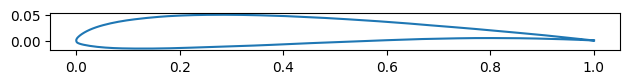

[]

In [11]:
samples = np.load('sample.npy')
samples = delete_intersect(samples)

fig, axs = plt.subplots(1, 1)
xhat, yhat = savgol_filter((samples[58,:,0], samples[58,:,1]), 10, 3)
samples[58,:,0] = xhat
samples[58,:,1] = yhat
axs.plot(samples[58,:,0], samples[58,:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

detect_intersect(samples[58,:,:])

intersect = []
for i in range(samples.shape[0]):
    xhat, yhat = savgol_filter((samples[i,:,0], samples[i,:,1]), 10, 3)
    samples[i,:,0] = xhat
    samples[i,:,1] = yhat
    af = samples[i,:,:]
    if detect_intersect(af):
        intersect.append(i)
intersect

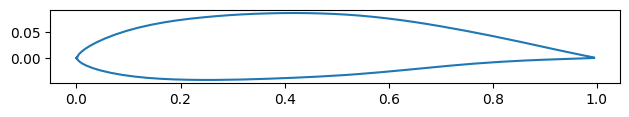

In [12]:
fig, axs = plt.subplots(1, 1)
xhat, yhat = savgol_filter((samples[4,:,0], samples[4,:,1]), 5, 3)
samples[4,:,0] = xhat
samples[4,:,1] = yhat
axs.plot(samples[4,:,0], samples[4,:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

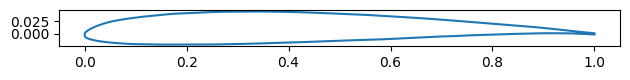

In [13]:
fig, axs = plt.subplots(1, 1)
axs.plot(airfoil1D[:,0], airfoil1D[:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

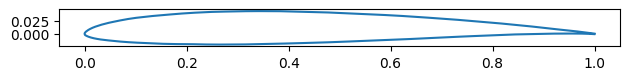

In [14]:
fig, axs = plt.subplots(1, 1)
axs.plot(airfoil[:,0], airfoil[:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

In [15]:
def derotate(airfoil):
    ptail = 0.5 * (airfoil[0,:]+airfoil[-1,:])
    ptails = np.expand_dims(ptail, axis=0)
    ptails = np.repeat(ptails, 256, axis=0)
    i = np.linalg.norm(airfoil - ptails, axis=1).argmax()
    phead = airfoil[i,:]
    theta = np.arctan2(-(airfoil[i,1] - ptail[1]), -(airfoil[i,0] - ptail[0]))
    c = np.cos(theta)
    s = np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    airfoil_R = airfoil
    airfoil_R -= np.repeat(np.expand_dims(phead, axis=0), 256, axis=0)
    airfoil_R = np.matmul(airfoil_R, R)
    return airfoil_R

def Normalize(airfoil):
    r = np.maximum(airfoil[0,0], airfoil[-1,0])
    r = float(1.0/r)
    return airfoil * r

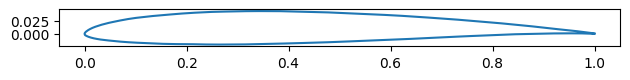

In [16]:
airfoil_R = derotate(airfoil)
airfoil_R = Normalize(airfoil_R)
fig, axs = plt.subplots(1, 1)
axs.plot(airfoil_R[:,0], airfoil_R[:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

In [17]:
ptail = 0.5 * (airfoil_R[0,:]+airfoil_R[-1,:])
ptails = np.expand_dims(ptail, axis=0)
ptails = np.repeat(ptails, 256, axis=0)
i = np.linalg.norm(airfoil_R - ptails, axis=1).argmax()
phead = airfoil_R[i,:]
theta = np.arctan2(-(airfoil_R[i,1] - ptail[1]), -(airfoil_R[i,0] - ptail[0]))
phead

array([0., 0.])

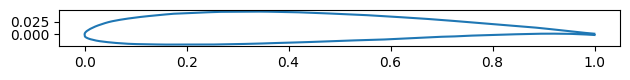

In [18]:
airfoil_R1D = derotate(airfoil1D)
airfoil_R1D = Normalize(airfoil_R1D)
fig, axs = plt.subplots(1, 1)
axs.plot(airfoil_R1D[:,0], airfoil_R1D[:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

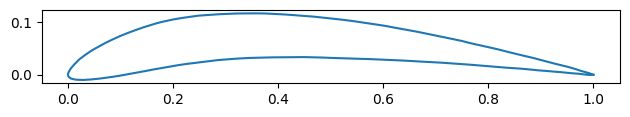

In [19]:
samples = np.load('/work3/s212645/DiffusionAirfoil/Airfoils/000.npy')
i = 23
fig, axs = plt.subplots(1, 1)
xhat, yhat = savgol_filter((samples[i,:,0], samples[i,:,1]), 5, 3)
samples[i,:,0] = xhat
samples[i,:,1] = yhat
axs.plot(samples[i,:,0], samples[i,:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

In [20]:
from scipy.interpolate import splev, splprep, interp1d
from scipy.integrate import cumtrapz

def interpolate(Q, N, k, D=20, resolution=1000):
    ''' Interpolate N points whose concentration is based on curvature. '''
    res, fp, ier, msg = splprep(Q.T, u=None, k=k, s=1e-6, per=0, full_output=1)
    tck, u = res
    uu = np.linspace(u.min(), u.max(), resolution)
    x, y = splev(uu, tck, der=0)
    dx, dy = splev(uu, tck, der=1)
    ddx, ddy = splev(uu, tck, der=2)
    cv = np.abs(ddx*dy - dx*ddy)/(dx*dx + dy*dy)**1.5 + D
    cv_int = cumtrapz(cv, uu, initial=0)
    fcv = interp1d(cv_int, uu)
    cv_int_samples = np.linspace(0, cv_int.max(), N)
    u_new = fcv(cv_int_samples)
    x_new, y_new = splev(u_new, tck, der=0)
    xy_new = np.vstack((x_new, y_new)).T
    return xy_new

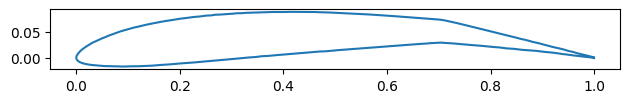

In [21]:
samples = np.load('/work3/s212645/DiffusionAirfoil/Airfoils/000.npy')
i = 30
airfoil = samples[i,:,:]
def setflap(af, theta = 8, pose = 0.7):
    airfoil = np.copy(af)
    phead_i = airfoil[:,0].argmin()
    pflap_i_down = abs(airfoil[:phead_i,0] - pose).argmin()
    pflap_i_up = abs(airfoil[phead_i:,0] - pose).argmin() + phead_i
    theta = theta * np.pi / 180
    c = np.cos(theta)
    s = np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    if theta < 0:
        p_mid = airfoil[pflap_i_down,:]
    else:
        p_mid = airfoil[pflap_i_up,:]
    airfoil[pflap_i_up:,:] = np.matmul(airfoil[pflap_i_up:,:] - p_mid, R) + p_mid
    airfoil[:pflap_i_down,:] = np.matmul(airfoil[:pflap_i_down,:] - p_mid, R) + p_mid
    airfoil = interpolate(airfoil, 256, 3)
    airfoil = derotate(airfoil)
    airfoil = Normalize(airfoil)
    return airfoil

airfoil = setflap(airfoil)
fig, axs = plt.subplots(1, 1)
axs.plot(airfoil[:,0], airfoil[:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

In [22]:
from xfoil import XFoil
from utils import *
def evalpreset(airfoil):
    xf = XFoil()
    xf.print = 0
    xf.airfoil = Airfoil(airfoil[:,0], airfoil[:,1])
    xf.Re = 4e5
    xf.max_iter = 2000
    a, CL, CD, cm, cp = xf.aseq(-2, 2, 0.5)
    i_nan = np.argwhere(np.isnan(CD))
    a = np.delete(a, i_nan)
    CD = np.delete(CD, i_nan)
    try:
        i_min = CD.argmin()
        CD = CD[i_min]
        a = a[i_min]
    except:
        CD = np.nan
    return CD, a

def evalperf(airfoil, cl = 0.65):
    xf = XFoil()
    xf.print = 0
    xf.airfoil = Airfoil(airfoil[:,0], airfoil[:,1])
    xf.Re = 5.8e4
    xf.max_iter = 2000
    a, cd, cm, cp = xf.cl(cl)
    perf = cl/cd
    return perf, a, cd

def launch_alpha(airfoil):
    alpha = np.linspace(-3,0,num=4)
    ail = np.linspace(0.6,0.7,num=3)
    a_BL = -3
    b_BL = 0.6
    CD_BL = 10
    af_BL = airfoil
    Angle = 0
    for a in alpha:
        for b in ail:
            af = setupflap(airfoil, a, b)
            CD, aa = evalpreset(af)
            if CD < CD_BL:
                CD_BL = CD
                a_BL = a
                b_BL = b
                af_BL = af
                Angle = aa
    return a_BL, b_BL, CD_BL, af_BL, Angle


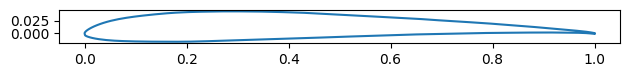

In [23]:
airfoil = np.loadtxt('samples/Airfoils1D000.dat')

fig, axs = plt.subplots(1, 1)
axs.plot(airfoil[:,0], airfoil[:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()


In [24]:
# af = np.loadtxt('samples/Airfoils1D000F.dat')
# af = setupflap(af)
# np.savetxt('samples/Airfoils1D000F -2.dat', af)

# a_BL, b_BL, CD_BL, airfoil, a = launch_alpha(airfoil)
# fig, axs = plt.subplots(1, 1)
# axs.plot(airfoil[:,0], airfoil[:,1])
# axs.set_aspect('equal', 'box')
# fig.tight_layout()
# plt.show()

# np.savetxt('samples/Airfoils1D000 -2.dat', airfoil)
# detect_intersect(airfoil), CD_BL, a_BL, b_BL, a

In [25]:
def cruise_alpha(airfoil, pose = 0.7):
    alpha = np.linspace(0,5,num=6)
    a_BL = 0
    perf_BL = 0
    af_BL = airfoil
    Angle = 0
    for a in alpha:
        af = setflap(airfoil, a, pose)
        perf, aa, cd = evalperf(af)
        if perf > perf_BL:
            perf_BL = perf
            a_BL = a
            af_BL = af
            Angle = aa
    return a_BL, perf_BL, af_BL, Angle
# a_BL, perf_BL, airfoil_c, a = cruise_alpha(airfoil, pose=b_BL)
# fig, axs = plt.subplots(1, 1)
# axs.plot(airfoil_c[:,0], airfoil_c[:,1])
# axs.set_aspect('equal', 'box')
# fig.tight_layout()
# plt.show()
# np.savetxt('samples/Airfoils1D000F.dat', airfoil_c)
# a_BL, perf_BL, a

In [26]:
airfoil = np.loadtxt('samples/Airfoils1D000.dat')

def lowestD(airfoil):
    if detect_intersect(airfoil):
        # print('Unsuccessful: Self-intersecting!')
        af_BL, R_BL, a_BL, b_BL, perfBL, cdbl, CD_BL = airfoil, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    elif abs(airfoil[:128,1] - np.flip(airfoil[128:,1])).max() < 0.055 or abs(airfoil[:128,1] - np.flip(airfoil[128:,1])).max() > 0.08:
        # print('Unsuccessful: Too thin!')
        af_BL, R_BL, a_BL, b_BL, perfBL, cdbl, CD_BL = airfoil, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    elif np.abs(airfoil[0,0]-airfoil[-1,0]) > 0.01 or np.abs(airfoil[0,1]-airfoil[-1,1]) > 0.01:
        # print('Unsuccessful:', (airfoil[0,0],airfoil[-1,0]), (airfoil[0,1],airfoil[-1,1]))
        af_BL, R_BL, a_BL, b_BL, perfBL, cdbl, CD_BL = airfoil, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    else:
        alpha = np.linspace(-3,0,num=4)
        ail = np.linspace(0.6,0.7,num=3)
        R_BL = 10
        CD_BL = 10
        a_BL = -3
        b_BL = 0.6
        perfBL = 0
        cdbl = 10
        af_BL = airfoil
        for a in alpha:
            for b in ail:
                af = setupflap(airfoil, a, b)
                CD, aa = evalpreset(af)
                afc = setflap(af, -a, b)
                perf, aa, cd = evalperf(afc)
                R = cd + CD * 3
                if R < R_BL:
                    R_BL = R
                    a_BL = a
                    b_BL = b
                    af_BL = af
                    perfBL = perf
                    cdbl = cd
                    CD_BL = CD
    return af_BL, R_BL, a_BL, b_BL, perfBL, cdbl, CD_BL



In [27]:
# airfoil, R, a, b, perf, cd, CD_BL = lowestD(airfoil)
# fig, axs = plt.subplots(1, 1)
# axs.plot(airfoil[:,0], airfoil[:,1])
# axs.set_aspect('equal', 'box')
# fig.tight_layout()
# plt.show()
# R, a, b, perf, cd, CD_BL

In [28]:
# np.savetxt('samples/Airfoils1D000F.dat', airfoil)

In [ ]:
import logging
logging.basicConfig(filename='results/perf1D.log', encoding='utf-8', level=logging.DEBUG)

R_BL = 0.031195905059576035
perf_BL = 39.06369801476684
CD_BL = 0.004852138459682465
cl = 0.65
best_perf=perf_BL
best_airfoil = None
name = 'Airfoils1D'
n = 0
m = 0
count = 0
i = 0
k = 0
airfoilpath = '/work3/s212645/DiffusionAirfoil/'+name+'/'

log = np.loadtxt('results/log.txt')
i = log[0]
k = log[1]
m = log[2]

while i < 100:
    logging.info(f'files: {i+count}')
    num = str(i+count).zfill(3)
    airfoils = np.load(airfoilpath+num+'.npy')
    airfoils = delete_intersect(airfoils)
    while k < airfoils.shape[0]:
        airfoil = airfoils[k,:,:]
        airfoil = derotate(airfoil)
        airfoil = Normalize(airfoil)
        xhat, yhat = savgol_filter((airfoil[:,0], airfoil[:,1]), 10, 3)
        airfoil[:,0] = xhat
        airfoil[:,1] = yhat
        af, R, a, b, perf, cd, CD_BL = lowestD(airfoil)
        if perf == np.nan:
            pass
        elif R < R_BL:
            mm = str(m).zfill(3)
            np.savetxt(f'BETTER/airfoil{mm}.dat', airfoil)
            np.savetxt(f'BETTER/airfoil{mm}F.dat', af)
            logging.info(f'perf: {perf}, R: {R}, m: {mm}')
            m += 1
        k += 1
        log = np.array([i, k, m])
        np.savetxt('results/log.txt', log)
    i += 1

In [4]:
import numpy as np
from utils import lowestD
points = 'samples/Airfoils1D_001.dat'
airfoil = np.loadtxt(points, skiprows=1)
af, R, a, b, perf, cd, CD_BL = lowestD(airfoil)
name = points.split('/')[1].split('.')[0]+f'_{a}_{b}F'
np.savetxt(points.split('.')[0]+f'_{a}_{b}F'+'.dat', af, header=points.split('/')[1].split('.')[0]+f'_{a}_{b}F', comments="")
R, a, b, perf, cd, CD_BL

perf:  39.66898221895291 R:  0.030599390622228384


(0.030599390622228384,
 -3.0,
 0.6,
 39.66898221895291,
 0.016385598108172417,
 0.004737930838018656)